In [157]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import math
from scipy.stats import multivariate_normal
from sklearn import preprocessing
%matplotlib inline

Text(0.5,1,'Wait time and the duration of the eruption')

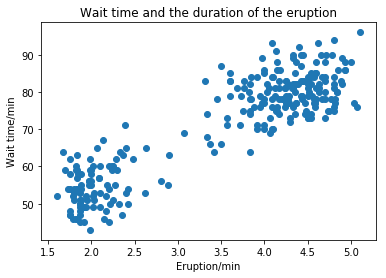

In [166]:
#(b)
data = np.loadtxt('data/q3.txt')
eruption = data[:,1]
wait = data[:,2]
plt.scatter(eruption,wait)
plt.xlabel("Eruption/min")
plt.ylabel("Wait time/min")
plt.title("Wait time and the duration of the eruption")

In [167]:
data = np.array(data[:,[1,2]])

In [184]:
#(c)
def gmm(data,k):
    n,d = np.shape(data)
    centroids = data[random.sample(range(n+1),d)] #initialize k samples as mean
    #store means in vectors
    mean_1 = []
    mean_2 = []
    
    mean_1.append(centroids[0])
    mean_2.append(centroids[1])
    #initialize param
    mu,pi,cov = init_params(data,centroids,k,n,d)
    
    #set convergence threshold
    threshold  = 1e-20
    prev_loss = -np.inf
    num_iter = 0
    while True:
        #E-step
        Px = norm_density(mu,cov,data,k,n,d) #n x k #pi: k x 1
        gamma = ((Px * pi).T/np.sum(Px * pi, axis=1).astype(float)).T #n x k
        
        #M-STEP
        mu = (np.matmul(gamma.T,data).T/np.sum(gamma,axis=0).astype(float)).T
        mean_1.append(mu[0])
        mean_2.append(mu[1])
        
        #update pSigma
        for cluster in range(k):
            x_u = data - mu[cluster]
            #print(np.shape(gamma[:,cluster]))
            var = np.dot(np.sum((x_u)**2, axis=1),gamma[:,cluster])/np.sum(gamma,axis=0)[cluster]
            cov[:,:,cluster] = var*np.identity(d)
        #update pi
        pi = np.sum(gamma,axis=0) / np.float(n)
        
        #check if stop
        L = np.sum(np.log(Px*pi))  
        if L-prev_loss < threshold:
            break        
        prev_loss = L
        num_iter += 1
        
    return Px, mean_1, mean_2,num_iter
        
    
def init_params(data,centroids,k,n,d):
    mu = centroids
    pi = np.zeros([1, k])  
    cov = np.zeros([d,d,k])
    dists = []
    #assign each data to closest centroid mu[c]
    for adata in data:
        dist2mu = []
        for c in range(k):
            dist2mu.append(np.linalg.norm(adata-mu[c]))
        dists.append(dist2mu)
    labels = np.argmin(dists,axis=1)
    
    for cluster in range(k):
        members = data[labels==cluster]
        pi[0][cluster] = float(np.shape(members)[0])/n
        cov[:,:,cluster] = np.diag(np.var(members,axis=0))
    
    return mu,pi,cov

    
def norm_density(mu,cov,data,k,n,d):
    # normal density   
    Px = []
    for cluster in range(k):
        rv = multivariate_normal(mu[cluster],cov[:,:,cluster])
        Px.append(rv.pdf(data))
    Px = np.asarray(Px)
    Px = Px.T
    return Px

In [177]:
Px, mean_1, mean_2, num_iter = gmm(data,2)

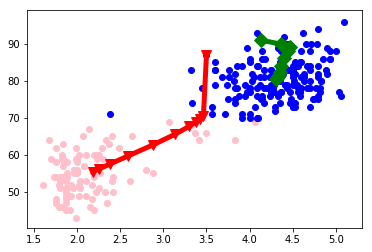

In [178]:
index = np.argmax(Px,axis=1) 
    
#dataset after clustering
plt.figure(1)
plt.scatter(data[index==0][:,0],data[index==0][:,1],c='pink')
plt.scatter(data[index==1][:,0],data[index==1][:,1],c=u'b')

#plot mean vectors
plt.plot(np.mat(mean_1)[:,0],np.mat(mean_1)[:,1],'rv-',markersize=10,linewidth=5)
plt.plot(np.mat(mean_2)[:,0],np.mat(mean_2)[:,1],'gD-',markersize=10,linewidth=5)


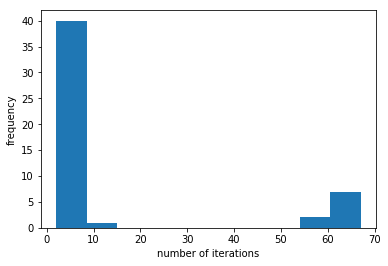

In [169]:
iter_list = []
for i in range(50):
    Px, mean_1, mean_2, num_iter = gmm(data,2)
    iter_list.append(num_iter)
plt.hist(iter_list)
plt.xlabel('number of iterations')
plt.ylabel('frequency')
plt.show()

In [180]:
def kmeans_gmm(data,k):
    n,d = np.shape(data)
    mean_1 = []
    mean_2 = []
    #initialize param
    mu,pi,cov = kmeans_params(data,k,n,d)
        
    mean_1.append(mu[0])
    mean_2.append(mu[1])
    #set convergence threshold
    threshold  = 1e-20
    prev_loss = -np.inf
    num_iter = 0
    while True:
        #E-step
        Px = norm_density(mu,cov,data,k,n,d) #n x k #pi: k x 1
        gamma = ((Px * pi).T/np.sum(Px * pi, axis=1).astype(float)).T #n x k
        
        #M-STEP
        mu = (np.matmul(gamma.T,data).T/np.sum(gamma,axis=0).astype(float)).T
        mean_1.append(mu[0])
        mean_2.append(mu[1])
        
        #update pSigma
        for cluster in range(k):
            x_u = data - mu[cluster]
            #print(np.shape(gamma[:,cluster]))
            var = np.dot(np.sum((x_u)**2, axis=1),gamma[:,cluster])/np.sum(gamma,axis=0)[cluster]
            cov[:,:,cluster] = var*np.identity(d)
        #update pi
        pi = np.sum(gamma,axis=0) / np.float(n)
        
        #check if stop
        L = np.sum(np.log(Px*pi))  
        if L-prev_loss < threshold:
            break        
        prev_loss = L
        num_iter += 1
        
    return Px, mean_1, mean_2,num_iter
        
    
def kmeans_params(data,k,n,d):
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    mu = kmeanModel.cluster_centers_
    
    pi = np.zeros([1, k])  
    cov = np.zeros([d,d,k]) #cov matrix of k components
    dists = []

    for cluster in range(k):
        member_indices = np.where(kmeanModel.labels_ == cluster)[0]
        cluster_members = data[member_indices,:]
        pi[0][cluster] = float(np.shape(cluster_members)[0])/n
        x_u = cluster_members - mu[cluster]
        cov[:,:,cluster] = np.matmul(x_u.T,x_u)/float(np.shape(cluster_members)[0])
    
    return mu,pi,cov

In [181]:
Px, mean_1, mean_2, num_iter = kmeans_gmm(data,2)

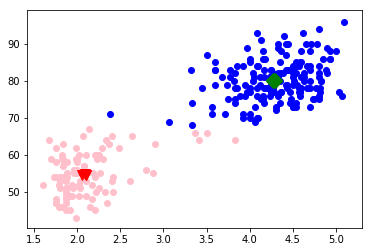

In [182]:
index = np.argmax(Px,axis=1) 
    
#plot dataset
plt.figure(1)
plt.scatter(data[index==0][:,0],data[index==0][:,1],c='pink')
plt.scatter(data[index==1][:,0],data[index==1][:,1],c=u'b')

#plot mean vectors
plt.plot(np.mat(mean_1)[:,0],np.mat(mean_1)[:,1],'rv-',markersize=10,linewidth=5)
plt.plot(np.mat(mean_2)[:,0],np.mat(mean_2)[:,1],'gD-',markersize=10,linewidth=5)

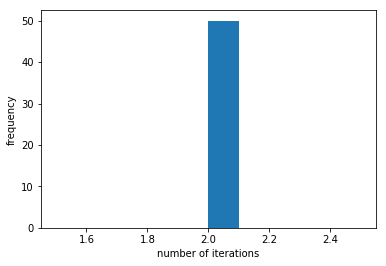

In [183]:
iter_list = []
for i in range(50):
    Px, mean_1, mean_2, num_iter = kmeans_gmm(data,2)
    iter_list.append(num_iter)
plt.hist(iter_list)
plt.xlabel('number of iterations')
plt.ylabel('frequency')
plt.show()